# The Battle of Neighborhood: Where to stay when you travel to Hong Kong?

### Applied Data Science Capstone by IBM/Coursera

## 1. Introduction 

### 1.1 Background Information

As a city with one of the most engaging and beautiful urban spectacles on Earth, Hong Kong has always been one of the top tourist destination. Although tourism is currently highly affected by Covid-19, but it believed that in a post-Covid-19 world there will be more small group and private tours and a move away from the larger coach tour-type experience according Hong Kong Free Press. Hence, while travelling in a small group of friends or family members, you might want consider to choose an Airbnb stay. 

Hong Kong Free Press news article:
https://hongkongfp.com/2020/06/13/coronavirus-how-does-a-tour-company-survive-when-hong-kong-has-no-tourists/

### 1.2 Problem Statement

According to Inside Airbnb, there are up to 11,187 accommodation listings in Hong Kong in year 2020. Therefore, it can be hard to find the right accomodation to rent via Airbnb service.

In this project, we will try to investigate the most optimal location in Hong Kong where travellers can enjoy a pleasent stay, possibly having a varieties of restaurants nearby and a convinient journey to travel attractions in Hong Kong.


### 1.3 Target Audience

This report is an analysis of Airbnb accommodation listings in Hong Kong customized to travellers who would like to visit Hong Kong and provide suggestions on location of stay.

## 2. Data

### 2.1 Data Require

* Average accommodation price based on neighborhood
* Number of venues including tourists attractions, restaurants and shopping malls in neighborhood

### 2.2 Data Sources

In this project, we will be using free public available dataset. Below is the link to the dataset.

* Airbnb accommodation data from Inside Airbnb:
    http://insideairbnb.com/get-the-data.html (Data compiled on 15 June 2020)
    
* Foursquare API to extract data on venue in a neighbourhood:
    https://developer.foursquare.com/ 

### 2.3 Libraries Used

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium

print('Libraires imported')

Libraires imported


### 2.4 Data Preparation

#### Airbnb Data from Inside Airbnb

Data file is downloaded from Inside Airbnb: http://insideairbnb.com/get-the-data.html  
This is the direct link to download the data file:  http://data.insideairbnb.com/china/hk/hong-kong/2020-06-15/data/listings.csv.gz

Let's read the csv file into dataframe and observe our dataset.

In [2]:
df = pd.read_csv('Downloads/HK Airbnb Data/listings.csv~1/listings.csv', low_memory = False)

In [3]:
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,69074,https://www.airbnb.com/rooms/69074,20200615133603,2020-06-17,Beautiful oasis of plants & art @ best location,An ideal Hong location any visitor--hip withou...,"Filled with plants and art, this one bedroom u...",An ideal Hong location any visitor--hip withou...,none,"In the upper part of trendy, hip Sheung Wan, w...",...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.18
1,75083,https://www.airbnb.com/rooms/75083,20200615133603,2020-06-17,SoHo off Hollywood Road 3B,"Located steps from Hollywood road, with new ea...","Located on Hollywood Road, walking distance to...","Located steps from Hollywood road, with new ea...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,13,9,4,0,2.02
2,103760,https://www.airbnb.com/rooms/103760,20200615133603,2020-06-17,Central Centre 5 min walk to/from Central MTR,"Located right in the heart of Central, this 2 ...",You really can't ask for a better location. I...,"Located right in the heart of Central, this 2 ...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,13,9,4,0,2.47


In [4]:
df.shape

(11187, 106)

In order to work better with the data, the followings are performed on the dataframe:
1. Only include "id", "neighbourhood_cleansed", "latitude", "longitude", "room_type", "price", "cleaning_fee", "guests_included", "extra_people","minimum nights", "availability_365", "review_scores_rating" and "number_of_reviews" columns  
  
2. Filter the data with fthe followings conditions:  
    a. Minimum nights >= 1 and < 3  
    b. Number of reviews >= 10  
    c. Exclude shared room  
    d. Availability >= 10 days/year  

In [5]:
# Remove columns
df1 = df[["id", "neighbourhood_cleansed", "latitude", "longitude", "room_type", "price", "guests_included", "extra_people",
           "cleaning_fee", "minimum_nights", "availability_365", "review_scores_rating", "number_of_reviews"]]

In [6]:
# Filter data
df1 = df1[(df1.minimum_nights >= 1)
           & (df1.minimum_nights < 3 )
           & (df1.number_of_reviews >= 10)
           & (~df1.room_type.isin(['Shared room']) )
           & (df1.availability_365 >= 10)
          ]

df1 = df1.reset_index(drop = True)

df1.shape

(1883, 13)

In [7]:
df1.head(3)

,id,neighbourhood_cleansed,latitude,longitude,room_type,price,guests_included,extra_people,cleaning_fee,minimum_nights,availability_365,review_scores_rating,number_of_reviews
0,132773,Central & Western,22.28868,114.14494,Entire home/apt,"$1,046.00",3,$225.00,$302.00,2,345,93.0,305
1,133390,Central & Western,22.28343,114.15539,Entire home/apt,$930.00,1,$0.00,NaN,2,135,97.0,27
2,163664,Central & Western,22.28651,114.14874,Entire home/apt,$690.00,2,$194.00,$302.00,2,338,86.0,222


Here is the description for each column:

* id: unique id for each accommodation

* neighbourhood_cleansed:        neighbourhood name that the accommodation is located
  
* latitude:             latitude of accommodation location
* longitude:            longitude of accommodation location
* room_type:            accommodation room type
* price:                price of accommodation per night
* cleaning_fee:         cleaning fee of accommodation
* minimum_nights:       minimum nights of stay
* availability_365:     accommodation's availability days per year
* number_of_reviews:    number of reviews in total

Now, check that if there is any null values in the dataframe.

In [8]:
df1.isnull().sum()

id                          0
neighbourhood_cleansed      0
latitude                    0
longitude                   0
room_type                   0
price                       0
guests_included             0
extra_people                0
cleaning_fee              627
minimum_nights              0
availability_365            0
review_scores_rating        0
number_of_reviews           0
dtype: int64

Seems like we have a lot of null values in our "cleaning_fee" column. We can replace the null with $0.

In [9]:
df1['cleaning_fee'] = df1['cleaning_fee'].fillna('$0')

In [10]:
df1.isnull().sum()

id                        0
neighbourhood_cleansed    0
latitude                  0
longitude                 0
room_type                 0
price                     0
guests_included           0
extra_people              0
cleaning_fee              0
minimum_nights            0
availability_365          0
review_scores_rating      0
number_of_reviews         0
dtype: int64

Here is an overview of the data types of each column.

In [11]:
df1.dtypes

id                          int64
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
room_type                  object
price                      object
guests_included             int64
extra_people               object
cleaning_fee               object
minimum_nights              int64
availability_365            int64
review_scores_rating      float64
number_of_reviews           int64
dtype: object

Now, we would like to remove the "$" and "," symbol from "price", "extra_people" and "cleaning_fee" column and change the data type from object to float64 for calculation prupose later.

In [12]:
df1['price'] = df1['price'].str.replace(',', '').str.replace('$', '').astype('float')
df1['cleaning_fee'] = df1['cleaning_fee'].str.replace(',', '').str.replace('$', '').astype('float')
df1['extra_people'] = df1['extra_people'].str.replace(',', '').str.replace('$', '').astype('float')

In [13]:
df1.dtypes

id                          int64
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
room_type                  object
price                     float64
guests_included             int64
extra_people              float64
cleaning_fee              float64
minimum_nights              int64
availability_365            int64
review_scores_rating      float64
number_of_reviews           int64
dtype: object

We would want to add the price and the mandatory cleaning fee for the accommondation to get the full price.

In [14]:
df1['full_price'] = df1['price'] + df1['cleaning_fee']

We will now check for outliers in the "full_price" columns

Text(0.5, 0.98, '')

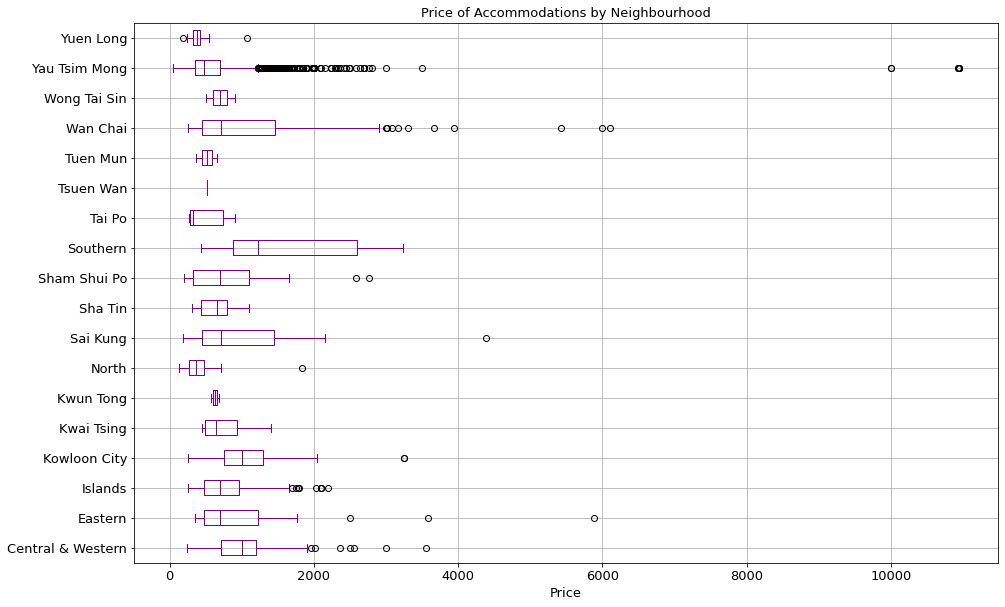

In [15]:
# Plot a box plot
box = df1[['neighbourhood_cleansed','full_price']].boxplot(
    column='full_price', 
    by='neighbourhood_cleansed',
    vert=False, 
    fontsize=13, 
    figsize=(15,10),
    color = 'purple'
)

box.get_figure().gca().set_title("Price of Accommodations by Neighbourhood", fontsize=13)
box.get_figure().gca().set_xlabel('Price', fontsize=13)
box.get_figure().suptitle('')

From the box plot above, we can abserve that there are some points that distant away from other observations.  
Hence, we will remove any points that is not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) 

In [75]:
# Calculate Q1, Q3 and IQR
Q1 = df1.price.quantile(0.25)
Q3 = df1.price.quantile(0.75)
IQR = Q3 - Q1

# Remove data that is not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR)
condition = (df1.price >= Q1 - 1.5 * IQR) & (df1.price <= Q3 + 1.5 *IQR)
df1 = df1.loc[condition]  

df1.shape

(1701, 15)

Plot another box plot with our new dataframe after outliers removed 

Text(0.5, 0.98, '')

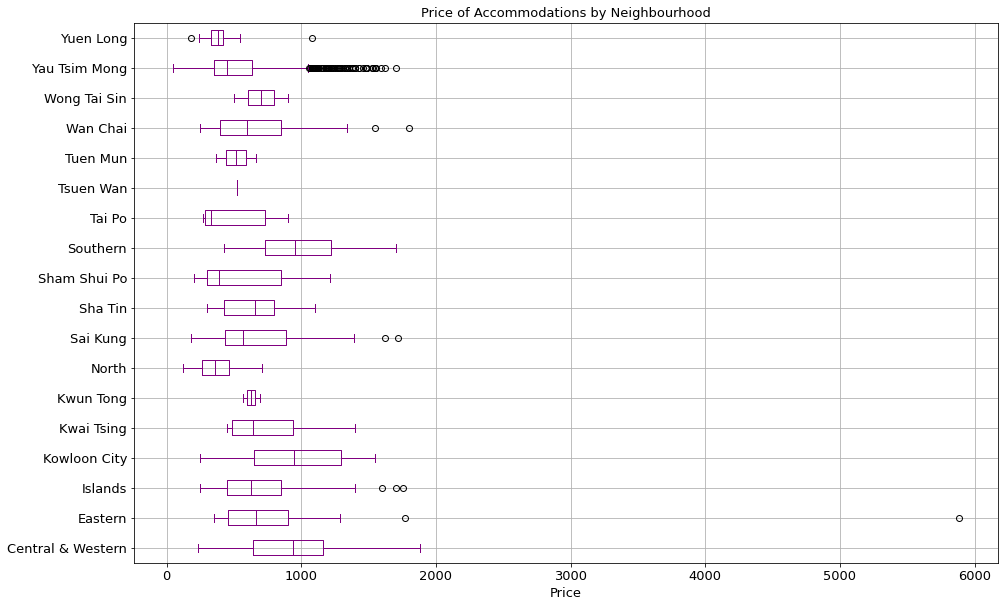

In [76]:
# Plot a box plot
box = df1[['neighbourhood_cleansed','full_price']].boxplot(
    column='full_price', 
    by='neighbourhood_cleansed',
    vert=False, 
    fontsize=13, 
    figsize=(15,10),
    color = 'purple'
)

box.get_figure().gca().set_title("Price of Accommodations by Neighbourhood", fontsize=13)
box.get_figure().gca().set_xlabel('Price', fontsize=13)
box.get_figure().suptitle('')

After preparing the dataframe, we can perform further analysis on df1.

## 3. Methodology

In this section, we will first perform an exploratory data analysis to further understand our dataset before we start solving our problem with machine learning algorithms.  

In our exploratory data analysis, we will investigate the average price per person to stay in a neighbourhood and plot a map to visualise the distribution of accommodations across Hong Kong.

Then, we will rank top 100 accommodations base on ratings and price.  

After that, we will use Foursquare API to obtain informations on venues nearby to our top 100 accommodations.  

In our final step, we will cluster our accommodations with k-means clustering and provide recommendations to travellers.

### 3.1 Exploratory Data Analysis

We will first calculate the average price per person for each accommodation.

In [18]:
df1['avg_price'] = df1.price / df1.guests_included

Then, we will calculate the mean for average price per person in each neighbourhood. 

In [19]:
# dataframe with mean of average price per person in each neighbourhood
df2 = df1.groupby("neighbourhood_cleansed", as_index = False).agg({"avg_price":"mean"})
df2 = df2.sort_values("avg_price").reset_index(drop = True)

Now, let's plot a graph to visualise the average price per person in each neighbourhood.

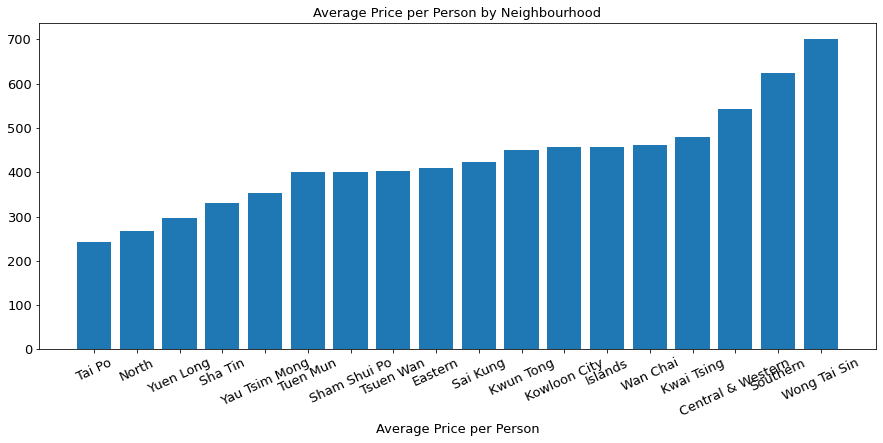

In [20]:
# plot a bar graph on Average Price per Person by Neighbourhood
fig, ax = plt.subplots(figsize=(15,6))
x = df2.neighbourhood_cleansed
y = df2.avg_price
ax.bar(x, y)
ax.set_xlabel('Average Price per Person', fontsize = 13)
ax.set_title('Average Price per Person by Neighbourhood', fontsize = 13)
plt.xticks(x, rotation=25)
plt.tick_params(labelsize=13)
plt.show()

Plot a map to visualise the distribution of accommodations across Hong Kong.

In [21]:
m = folium.Map(location=[22.3193,114.1694],zoom_start=10)

for lat, lon, neigh in zip(df1['latitude'],df1['longitude'],df1['neighbourhood_cleansed']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lon],
    radius=4,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.5,
    parse_html=False).add_to(m)

m

#### Map plotted might not be showed. Please visit Images folder for Map 3.PNG

### 3.2 Rank Top 100 Accommodations

Now, we will rank top 100 accommodations base on ratings and price.

In [23]:
df1.head(2)

,id,neighbourhood_cleansed,latitude,longitude,room_type,price,guests_included,extra_people,cleaning_fee,minimum_nights,availability_365,review_scores_rating,number_of_reviews,full_price,avg_price
0,132773,Central & Western,22.28868,114.14494,Entire home/apt,1046.0,3,225.0,302.0,2,345,93.0,305,1348.0,348.666667
1,133390,Central & Western,22.28343,114.15539,Entire home/apt,930.0,1,0.0,0.0,2,135,97.0,27,930.0,930.000000


In [24]:
limit=100
df_top = df1.sort_values(by=['review_scores_rating',  'full_price','avg_price'], 
                                         ascending=[False, True, True])[['id', 'neighbourhood_cleansed','latitude', 'longitude' ,
                                                                         'review_scores_rating', 'room_type','full_price', 
                                                                         'avg_price']].head(limit)

df_top = df_top.reset_index(drop=True)

In [25]:
df_top.head()

,id,neighbourhood_cleansed,latitude,longitude,review_scores_rating,room_type,full_price,avg_price
0,36411456,North,22.53460,114.11698,100.0,Entire home/apt,264.0,264.0
1,28270585,Yau Tsim Mong,22.29807,114.17356,100.0,Private room,302.0,302.0
2,25888892,Yau Tsim Mong,22.32096,114.16837,100.0,Private room,341.0,341.0
3,31976994,Wan Chai,22.27776,114.17544,100.0,Private room,352.0,302.0
4,31476198,Yau Tsim Mong,22.31850,114.16845,100.0,Private room,380.0,380.0


### 3.3 Get Venues Nearby with Foursquare API

Link to Foursquare API: https://foursquare.com/developers/apps  
To use Foursquare API, we need to definde Foresquare Credentials and Version.

In [145]:
CLIENT_ID = 'EOHTGEW0I443LRDRRQSD3PHVFYPA5SRJPRH3Y3YT3EFTDTXE' # your Foursquare ID
CLIENT_SECRET = 'YH2TGUCUWYSRKKSWZ5MBK5M2E5PDDJJIHZW0ZFULM3RCZIKP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 700 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EOHTGEW0I443LRDRRQSD3PHVFYPA5SRJPRH3Y3YT3EFTDTXE
CLIENT_SECRET:YH2TGUCUWYSRKKSWZ5MBK5M2E5PDDJJIHZW0ZFULM3RCZIKP


The following is a function that takes neighbourhood, latitude and longitude as input and gives back the venues around the location provided:

In [146]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['id', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [147]:
df_v = getNearbyVenues(names=df_top['id'],
                       latitudes=df_top['latitude'],
                       longitudes=df_top['longitude'],
                       radius = radius,
                       limit = LIMIT
                      )

In [148]:
df_v.head(3)

,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,36411456,22.5346,114.11698,Shangri-La Shenzhen (深圳香格里拉大酒店),22.536070,114.113102,Hotel
1,36411456,22.5346,114.11698,山小屋,22.534944,114.113125,Noodle House
2,36411456,22.5346,114.11698,Starbucks (星巴克),22.539862,114.114082,Coffee Shop


In [149]:
df_v.shape

(3648, 7)

We need to categorise venue category into the following custom categories:  
a. Food  
b. Entertainment  
c. Shopping  
d. Transport  
e. Fine Art  

We will define our custom categories as below:

In [152]:
food = ['Restaurant', 'Food', 'Café', 'Coffee', 'Cha Chaan Teng', 'Desert', 'Bakery', 'Snack', 'Burger', 
        'Steakhouse', 'Buffet', 'Sandwich', 'Bubble Tea', 'Ice Cream', 'Noodle']

entertainment = ['Aquarium', 'Theme Park', 'Scenic Lookout', 'Skate Park', 'Karaoke', 'Pub', 'Wine', 'Bar', 
                 'Spa', 'Gastropub', 'Liquor']

shopping = ['Shopping', 'Boutique', 'Clothing', 'Cosmetics', 'Jewelry']

outdoor = ['Court', 'Trail', 'Bay', 'Field', 'Park', 'Beach', 'Waterfront', 'Stadium', 'Garden', 'Plaza', 'Campground']

transport = ['Tram', 'Station', 'Bus']

fineart = ['Museum', 'Historic', 'Temple', 'Art']

In [153]:
cat = food + entertainment + shopping + outdoor + transport + fineart

Now, let's categorise our venues into our custom categories with the following functions:

In [154]:
# Get venues from custom categories
def getvenues(category):
    if any(word in category for word in cat):
        return True
    return False

In [155]:
# Define venues by our custom categories
def custom_cat(x):
    if any(word in x for word in food):
        return 'Food'
    if any(word in x for word in entertainment):
        return 'Entertainment'
    if any(word in x for word in shopping):
        return 'Shopping'
    if any(word in x for word in outdoor):        
        return 'Outdoor'
    if any(word in x for word in transport):            
        return 'Transport'
    if any(word in x for word in fineart):            
        return 'Fine Art'

In [156]:
# Get top venues
def common_venues(row, n):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)      
    return row_categories_sorted.index.values[0:n] 

def common_venues_count(row, n):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).astype(float)      
    return row_categories_sorted.values[0:n]

Input our data into the functions above

In [157]:
# Here, we exclude data that is not included in our custom categories
df_v2 = df_v[df_v['Venue Category'].apply(lambda x: getvenues(x))].reset_index(drop=True)

In [158]:
# Here, we add a new custom category column to our dataframe 
df_v2['custom_category']= df_v2['Venue Category'].apply(lambda x: custom_cat(x))

In [159]:
df_v2.head(3)

,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,custom_category
0,36411456,22.5346,114.11698,山小屋,22.534944,114.113125,Noodle House,Food
1,36411456,22.5346,114.11698,Starbucks (星巴克),22.539862,114.114082,Coffee Shop,Food
2,36411456,22.5346,114.11698,Shang Palace (香宫),22.535970,114.112622,Chinese Restaurant,Food


### 3.4 One Hot Encoding and K-means Clustering

We can now determine the top 3 venues for each accoommodation.  
This can be done with one hot encoding.


In [160]:
# one hot encoding
df_onehot = pd.get_dummies(df_v2[['custom_category']], prefix="", prefix_sep="")

In [161]:
# This is to place the id column back to our dataframe
df_onehot['id'] = df_v['id'] 

In [162]:
df_group = (np.round(df_onehot.groupby('id').mean(),2)).reset_index()

In [163]:
df_group.head(3)

,id,Entertainment,Fine Art,Food,Outdoor,Shopping,Transport
0,228510,0.06,0.0,0.86,0.04,0.02,0.02
1,3298455,0.02,0.0,0.76,0.04,0.12,0.06
2,3411574,0.00,0.0,0.75,0.25,0.00,0.00


Then, we get the top 3 venues of each accommodation

In [164]:
# top 3 venuew
n = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(n):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for ind in np.arange(n):
    try:
        columns.append('{}{} Most Common Venue Share'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Share'.format(ind+1))        
        

# create a new dataframe
df_group2 = pd.DataFrame(columns=columns)
df_group2['id'] = df_group['id']

for ind in np.arange(df_group.shape[0]):
    stats = np.around(common_venues_count(df_group.iloc[ind, :], n),2) 
    category = common_venues(df_group.iloc[ind, :], n)
    df_group2.iloc[ind, 1:] = np.concatenate([category, stats])


In [165]:
df_group2.head(3)

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,228510,Food,Entertainment,Outdoor,0.86,0.06,0.04
1,3298455,Food,Shopping,Transport,0.76,0.12,0.06
2,3411574,Food,Outdoor,Transport,0.75,0.25,0


Now, let's use k-means clustering to cluster our accommodations into 2 clusters

In [166]:
# set number of clusters
k = 2

df_cluster = df_group.drop('id', axis = 1)

# k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)

# add cluster label
df_group2.insert(0, 'Cluster Labels', kmeans.labels_)

In [167]:
df_group2.head(3)

,Cluster Labels,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,1,228510,Food,Entertainment,Outdoor,0.86,0.06,0.04
1,0,3298455,Food,Shopping,Transport,0.76,0.12,0.06
2,1,3411574,Food,Outdoor,Transport,0.75,0.25,0


Let's include latitude, longitude, neighbourhood_cleansed, review_scores_rating, room_type, full_price and avg_price to our dataframe.

In [168]:
df_merged = df_top.copy()
df_merged  = df_merged.join(df_group2.set_index('id'), on='id')
df_merged = df_merged.dropna()
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype('int')

In [169]:
df_merged.head(3)

,id,neighbourhood_cleansed,latitude,longitude,review_scores_rating,room_type,full_price,avg_price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,36411456,North,22.53460,114.11698,100.0,Entire home/apt,264.0,264.0,0,Food,Shopping,Entertainment,0.72,0.24,0.04
1,28270585,Yau Tsim Mong,22.29807,114.17356,100.0,Private room,302.0,302.0,1,Food,Entertainment,Shopping,0.78,0.12,0.08
2,25888892,Yau Tsim Mong,22.32096,114.16837,100.0,Private room,341.0,341.0,1,Food,Entertainment,Shopping,0.82,0.14,0.04


Let's determine which 3 neighbourhoods has the most accommodations included in the top 100 accommodations.  
Below is the top 3 neighbourhoods:  

In [170]:
top_neigh_count = df_merged.groupby(['neighbourhood_cleansed']).size().reset_index()
top_neigh_count = top_neigh_count.rename(columns={0:'Count', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('Count', ascending = False)

In [171]:
top_neigh_count.reset_index(drop=True).head(3)

,Airbnb Neighbourhood,Count
0,Yau Tsim Mong,20
1,Islands,10
2,Central & Western,9


In [172]:
top_neigh_mean = df_merged.groupby(['neighbourhood_cleansed']).mean().reset_index()
top_neigh_mean = top_neigh_mean[['neighbourhood_cleansed', 'full_price', 'avg_price']]

In [173]:
arr = top_neigh_count['Airbnb Neighbourhood'].reset_index(drop=True).head(3)
top_neigh_mean = top_neigh_mean.loc[top_neigh_mean['neighbourhood_cleansed'].isin(arr)].reset_index(drop=True)

In [174]:
top_neigh_mean[['neighbourhood_cleansed', 'full_price', 'avg_price']]

,neighbourhood_cleansed,full_price,avg_price
0,Central & Western,775.111111,545.555556
1,Islands,682.400000,507.300000
2,Yau Tsim Mong,496.350000,455.075000


Now, let's display our clusters on the map.

In [175]:
map_cluster = folium.Map(location=[22.3193,114.1694], zoom_start=12)

# set color for the clusters
x = np.arange(k)
ys = [x + i + (i*x)**2 for i in range(k)] 
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, cluster in zip(df_merged['latitude'], df_merged['longitude'], df_merged['neighbourhood_cleansed'], df_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_cluster)
       
map_cluster

#### Map plotted might not be shown. Please visit Images folder for Map 4.PNG

### 3.5 Investigate Each Cluster

#### 3.5.1 Cluster 0

In [177]:
clus0 = df_merged.loc[df_merged['Cluster Labels'] == 0]

In [178]:
clus0.describe()

,id,latitude,longitude,review_scores_rating,full_price,avg_price,Cluster Labels
count,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.0
mean,2.559217e+07,22.349638,114.135663,99.680000,724.720000,491.160000,0.0
std,1.001366e+07,0.100443,0.077056,0.476095,425.995552,284.092918,0.0
min,3.298455e+06,22.270760,113.944870,99.000000,205.000000,117.500000,0.0
25%,1.742896e+07,22.282590,114.116980,99.000000,403.000000,349.000000,0.0
50%,2.730389e+07,22.296020,114.168330,100.000000,511.000000,403.000000,0.0
75%,3.353298e+07,22.395220,114.175440,100.000000,1077.000000,581.000000,0.0
max,3.861705e+07,22.534600,114.297340,100.000000,1800.000000,1302.000000,0.0


clus0.neighbourhood_cleansed.value_counts()

In [179]:
clus0['1st Most Common Venue'].value_counts()

Food    25
Name: 1st Most Common Venue, dtype: int64

In [180]:
clus0['2nd Most Common Venue'].value_counts()

Entertainment    12
Shopping          9
Transport         4
Name: 2nd Most Common Venue, dtype: int64

In [181]:
clus0['3rd Most Common Venue'].value_counts()

Shopping         12
Entertainment     7
Outdoor           3
Transport         3
Name: 3rd Most Common Venue, dtype: int64

From the above results, we can conclude that for Cluster 0:  
* The average full price of an accommodation is $607.42 
* Accommondations in cluster 0 is mainly located at Yau Sim Mong, Central & Western and Islands
* The characteristic of cluster 0 is shopping

### 3.5.2 Cluster 1

In [182]:
clus1 = df_merged.loc[df_merged['Cluster Labels'] == 1]

In [183]:
clus1.describe()

,id,latitude,longitude,review_scores_rating,full_price,avg_price,Cluster Labels
count,4.700000e+01,47.000000,47.000000,47.000000,47.000000,47.000000,47.0
mean,2.388823e+07,22.330476,114.144361,99.404255,526.021277,432.946809,1.0
std,1.027895e+07,0.074917,0.081210,0.496053,151.328104,136.280810,0.0
min,2.285100e+05,22.223850,113.928020,99.000000,271.000000,151.000000,1.0
25%,1.569495e+07,22.286530,114.114840,99.000000,428.500000,341.000000,1.0
50%,2.592306e+07,22.301380,114.168300,99.000000,502.000000,426.000000,1.0
75%,3.194198e+07,22.336215,114.174160,100.000000,600.500000,531.000000,1.0
max,4.063049e+07,22.533200,114.323830,100.000000,963.000000,783.000000,1.0


In [184]:
clus1.neighbourhood_cleansed.value_counts()

Yau Tsim Mong        15
Islands               7
Central & Western     6
Wan Chai              3
Sai Kung              3
Yuen Long             3
Sha Tin               2
North                 2
Sham Shui Po          2
Tai Po                1
Kowloon City          1
Tsuen Wan             1
Wong Tai Sin          1
Name: neighbourhood_cleansed, dtype: int64

In [185]:
clus1['1st Most Common Venue'].value_counts()

Food    47
Name: 1st Most Common Venue, dtype: int64

In [186]:
clus1['2nd Most Common Venue'].value_counts()

Entertainment    25
Shopping          9
Outdoor           7
Transport         6
Name: 2nd Most Common Venue, dtype: int64

In [187]:
clus1['3rd Most Common Venue'].value_counts()

Shopping         14
Outdoor          12
Transport        11
Entertainment    10
Name: 3rd Most Common Venue, dtype: int64

From the above results, we can conclude that for Cluster 1:  
* The average full price of an accommodation is $592.76  
* Accommondations in cluster 1 is mainly located at Yau Sim Mong and Wan Chai and Islands    
* The characteristics of cluster 1 is outdoor activities

## 4. Results and Discussion

We observed that accommondations in cluster 0 and cluster 1 has many restaurants and entertainments nearby. Hence, travellers can comfortably enjoy dining in various restaurants and having fun near their accommodations.  

Also, transportations in Hong Kong is very convinient. Hence, travellers do not have to worry about transportations issues while choosing an accommodation between cluster 0 and cluster 1.  

Besides that, we investigated that Yau Tsim Mong is one of the best neighbourhood to stay at when you are travelling to Hong Kong as both cluster 0 and cluster 1 both has most accommodations located in Yau Tsim Mong.   

### Cluster 0

Characteristics: Shopping  
  
Traget audience: Travellers who enjoys shopping and looking forward to shop in Hong Kong.  

Average full price per night: $724.72  

Average price per person: $491.16  


### Cluster 1

Characteristics: Outdoor Activities

Traget audience: Travellers who wants go for camping, hiking or visitng the beach in Hong Kong.

Average full price per night: $526.02    

Average price per person: $432.95

### Price by Cluster

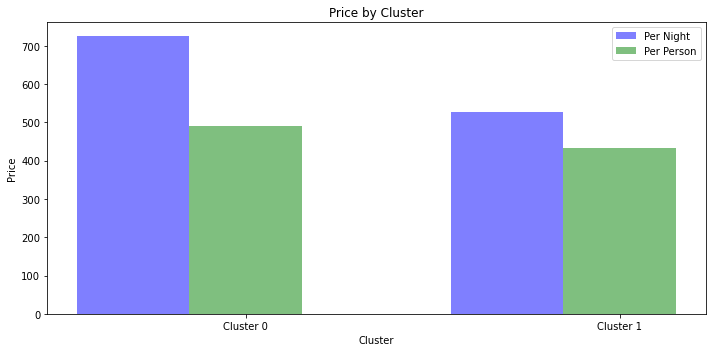

In [192]:
# data to plot
n_groups = 2
per_night = (724.72, 526.02)
per_person = (491.16, 432.95)

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.30
opacity = 0.5

rects1 = plt.bar(index, per_night, bar_width,
alpha=opacity,
color='b',
label='Per Night')

rects2 = plt.bar(index + bar_width, per_person, bar_width,
alpha=opacity,
color='g',
label='Per Person')

plt.xlabel('Cluster')
plt.ylabel('Price')
plt.title('Price by Cluster')
plt.xticks(index + bar_width, ('Cluster 0', 'Cluster 1'))
plt.legend()

plt.tight_layout()
plt.show()

### Neighbourhood

Below is a list to top three neighbourhoods for your choice:  
1. Yau Tsim Mong    
    Average full price per night: $496.35  
    
    Average price per person: $455.08  
         
       
2. Islands  
    Average full price per night: $682.40    
    
    Average price per person: $507.30  
       
       
3. Central & Western  
    Average full price per night: $755.11      
    
    Average price per person: $545.56    
    


### Price by Neighbourhood

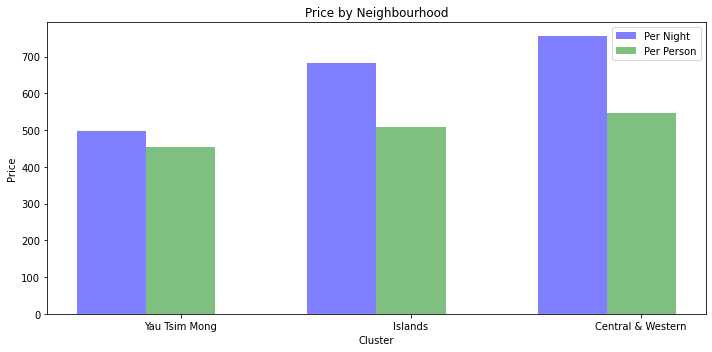

In [189]:
# data to plot
n_groups = 3
per_night = (496.35, 682.30, 755.11)
per_person = (455.08, 507.30, 545.56)

# create plot
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.30
opacity = 0.5

rects1 = plt.bar(index, per_night, bar_width,
alpha=opacity,
color='b',
label='Per Night')

rects2 = plt.bar(index + bar_width, per_person, bar_width,
alpha=opacity,
color='g',
label='Per Person')

plt.xlabel('Cluster')
plt.ylabel('Price')
plt.title('Price by Neighbourhood')
plt.xticks(index + bar_width, ('Yau Tsim Mong', 'Islands', 'Central & Western'))
plt.legend()

plt.tight_layout()
plt.show()

## 5. Conclusion

This project is to identify the places to stay in Hong Kong for travellers who would like a short stay visit in Hong Kong.  

By analysing data from Airbnb and nearby venues from FourSquare and using K-means clustering, we provided recommendations on places to stay for travellers based on price, location and their personal preferences. From the results of this project, travellers are able to choose a most suitable place to stay during their visit to Hong Kong. 

Of course, price, location and personal preferences are not the only criteria how travellers should make their final decision. There are additional factors like availability during their period of travel, number of travellers and condition of rooms and these factors also matter. However, this project can serve as an orientation and help travellers to start seraching the best place to stay.  

Besides that, there are improvements that can be made on the project. Due to limitations on Foursqaure API's free account, we can only analyse the top 100 accommodations. Hence, we can consider upgrading our account to analyse more accommodataions. Also, we can include analysis on the accommodations such as analyse the number of bathroom, the number of rooms, if there is a kitchen and if there is air-conditioner. 

## 6. Appendix

Below are some details about the lists of accommodations in cluster 0 and cluster 1. Travellers can search for the accommodations through the lisitn url.

### Cluster 0

In [190]:
clus0_id = pd.DataFrame(clus0.id).reset_index(drop=True)
detail_clus0 = clus0_id.join(df.set_index('id'), on='id')
detail_clus0[['listing_url','name','transit','access','neighbourhood_cleansed','room_type','accommodates',
             'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit','cleaning_fee', 'guests_included', 
             'extra_people']]

,listing_url,name,transit,access,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people
0,https://www.airbnb.com/rooms/36411456,每天全房间消毒走路1分钟过关罗湖口岸香港两房一厅楼下双地铁整房出租,NaN,NaN,North,Entire home/apt,4,1.0,2.0,3.0,$264.00,NaN,NaN,1,$0.00
1,https://www.airbnb.com/rooms/31976994,"Petite, Light, Bright & Happy Apartment","Located on the tram line, five minute walk fro...","Guest bedroom, Lounge room, kitchen and bathroom",Wan Chai,Private room,2,1.0,1.0,1.0,$302.00,$800.00,$50.00,1,$0.00
2,https://www.airbnb.com/rooms/31476198,"双人獨立套房,Room8,位於繁盛彌敦道,交通方便,全新裝修,干淨整潔,附近大型購物商場,購物方便",NaN,NaN,Yau Tsim Mong,Private room,2,1.5,0.0,1.0,$380.00,NaN,NaN,1,$0.00
3,https://www.airbnb.com/rooms/36396282,"Experience peace, tranquility in HK village house",Location We are situated about 10-15 minutes b...,NaN,Sai Kung,Private room,2,1.5,1.0,2.0,$395.00,NaN,$40.00,1,$0.00
4,https://www.airbnb.com/rooms/38617047,Cosy room with nice view; close to Airport and...,NaN,- No eating in the bedroom. - Can use the sitt...,Islands,Private room,1,1.0,1.0,1.0,$457.00,$0.00,$0.00,1,$150.00
5,https://www.airbnb.com/rooms/33532985,Ruby international Service apartment Room C,走路十二分鐘到達高鐡站 地鐵站步行一分鐘,"洗衣機, 空調",Yau Tsim Mong,Private room,2,1.0,1.0,1.0,$419.00,$0.00,$50.00,1,$0.00
6,https://www.airbnb.com/rooms/26052616,"位於香港九龍彌敦道全新裝修四人套房,附近有機場巴士及地鐵直達各景點及購物區,環境舒適安靜",NaN,NaN,Yau Tsim Mong,Private room,4,1.5,1.0,2.0,$496.00,NaN,NaN,1,$0.00
7,https://www.airbnb.com/rooms/35181203,Spacious Studio at the CENTER OF CAUSEWAY BAY!,Walking distance 5 min to Causeway Bay MTR Sta...,NaN,Wan Chai,Entire home/apt,3,1.0,1.0,1.0,$411.00,$0.00,$100.00,1,$100.00
8,https://www.airbnb.com/rooms/36369440,Luxury House千万豪宅/万象城/罗湖口岸/大剧院/京基100/荔枝公园/地王大厦/...,"《交通出行》 罗湖CBD区域,便捷出行及到达｡无缝接轨深圳机场､香港机场､蛇口码头,各大口岸...",房屋内所有设施都可以使用,North,Entire home/apt,6,2.0,3.0,3.0,$705.00,$109.00,$0.00,6,$55.00
9,https://www.airbnb.com/rooms/13211107,Private Room in convenient & spacious flat,NaN,NaN,Islands,Private room,2,1.0,1.0,1.0,$651.00,$0.00,$210.00,1,$0.00


### Cluster 1

In [191]:
clus1_id = pd.DataFrame(clus1.id).reset_index(drop=True)
detail_clus1 = clus1_id.join(df.set_index('id'), on='id')
detail_clus1[['listing_url','name','transit','access','neighbourhood_cleansed','room_type','accommodates',
             'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit','cleaning_fee', 'guests_included', 
             'extra_people']]

,listing_url,name,transit,access,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people
0,https://www.airbnb.com/rooms/28270585,"Single Rm, 1min MTR 침사추이 , Speaks Eng/한국어/中文 33s",Airport Bus - Take A21 airport bus from Hong K...,每间房间都有独立厕所和无线上网｡,Yau Tsim Mong,Private room,1,1.0,1.0,0.0,$302.00,NaN,NaN,1,$0.00
1,https://www.airbnb.com/rooms/25888892,"位於彌敦道雙床套房,交通便利,附近有機場巴士及旺角地鐵站,近購物區,方便往返中環､尖沙咀及各...",NaN,NaN,Yau Tsim Mong,Private room,2,1.0,1.0,2.0,$341.00,NaN,NaN,1,$0.00
2,https://www.airbnb.com/rooms/33533226,Ruby international Service apartment Room D,走路十二分鐘到達高鐡站 地鐵站步行一分鐘,"洗衣機, 空調",Yau Tsim Mong,Private room,2,1.0,1.0,1.0,$388.00,$0.00,$0.00,1,$0.00
3,https://www.airbnb.com/rooms/34503620,"【晨曦Dawn · 七栖】7号线赤尾站三口岸华强北九方､会展中心,巨幕投影白色简约风落地窗一房一厅",距离地铁7号线赤尾站C口步行350M 距离地铁7号线华强南站A口步行约400M 小区门口有公...,NaN,North,Entire home/apt,2,1.0,1.0,1.0,$326.00,NaN,$66.00,1,$0.00
4,https://www.airbnb.com/rooms/30354313,A Private Sanctuary in the Sai Kung Country Park,At the base of our drive way there is a bus st...,You will have full access to the many areas in...,Sai Kung,Private room,2,1.0,1.0,1.0,$450.00,$0.00,$0.00,1,$70.00
5,https://www.airbnb.com/rooms/15289502,"New decor apt for solo traveler, Sai Ying Pun, HK","MTR, mini-bus, bus, taxi are all convenient",NaN,Central & Western,Private room,1,1.0,0.0,1.0,$403.00,"$1,000.00",$60.00,1,$0.00
6,https://www.airbnb.com/rooms/36194838,福田中心区 紧邻地铁口 福田皇岗双口 会展 万象城 华强北多商 交通方便 清新简约套房 巨幕投影,NaN,NaN,North,Entire home/apt,2,1.0,1.0,1.0,$403.00,NaN,$66.00,1,$0.00
7,https://www.airbnb.com/rooms/25922562,"三人獨立套房位於繁盛的彌敦道,交通方便,附近有各式各類名店,購物方便,附近為旺角地鐵站,機場巴士",樓下有機場巴士直達機場,NaN,Yau Tsim Mong,Private room,3,1.0,1.0,2.0,$481.00,NaN,NaN,1,$0.00
8,https://www.airbnb.com/rooms/25923064,"三人獨立套房,位於繁盛彌敦道,全新裝修,交通方便,附近地鐵站,機場巴士,大型購物商場,購物方便",NaN,NaN,Yau Tsim Mong,Private room,3,1.0,1.0,2.0,$481.00,NaN,NaN,1,$0.00
9,https://www.airbnb.com/rooms/20704415,Cozy Room in Flat on Caine Road,public transport and taxis are readily availab...,"Shared spaces include the living room, bathroo...",Central & Western,Private room,1,1.0,1.0,1.0,$302.00,"$5,000.00",$200.00,1,$0.00
